### Project: Oil Spill Classification

Many imbalanced classification tasks require a skillful model that predicts a crisp class label,where both classes are equally important. The detection of a spill requires mobilizing an expensive response,and missing an event is equally expensive, causing damage to the environment.

One way to evaluate imbalanced classification models that predict crisp labels is to calculate the separate accuracy on the positive class and the negative class, referred to as sensitivity and specificity.  These two measures can then be averaged using the geometric mean, referred to as the G-mean, that is insensitive to the skewed class distribution and correctly reports on the skill of the model on both classes.

#### The Data

The dataset was introduced in the 1998 paperby Miroslav Kubat, et al.  titledMachine Learning for the Detection of Oil Spills in SatelliteRadar Images.  The dataset is often credited to Robert Holte, a co-author of the paper.  Thedataset was developed by starting with satellite images of the ocean, some of which contain anoil spill and some that do not.  Images were split into sections and processed using computervision algorithms to provide a vector of features to describe the contents of the image section orpatch.

*The input to [the system] is a raw pixel image from a radar satellite.  Image processingtechniques are used [...]  The output of the image processing is a fixed-length featurevector for each suspicious region.  During normal operation these feature vectors arefed into a classifier to decide which images and which regions within an image topresent for human inspection —Machine Learning for the Detection of Oil Spills in Satellite Radar Images, 1998.*

A total of nine satellite images were processed into patches.  Cases in the dataset are orderedby image and the first column of the dataset represents the patch number for the image.  This was provided for the purposes of estimating model performance per-image.  In this case, we arenot interested in the image or patch number and this first column can be removed.  The normal case is no oil spill assigned the class label of 0, whereas an oil spill is indicated by a class labelof 1.  There are 896 cases for no oil spill and 41 cases of an oil spill.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

sns.set()

In [12]:
#file_link = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv"
path = "data/oil-spill.csv"
data = pd.read_csv(path, index_col='0').drop(columns=  '22')
target = data.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / target.shape[0] * 100
    print("Class=%d, Count=%d, Percentage=%.3f%%" % (k, v, per))
print(data.shape)

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%
(937, 48)


We can also take a look at the distribution of each variable by creating a histogram for each.With 50 variables, it is a lot of plots, but we might spot some interesting patterns.  Also, with somany plots, we must turn off the axis labels and plot titles to reduce the clutter.  

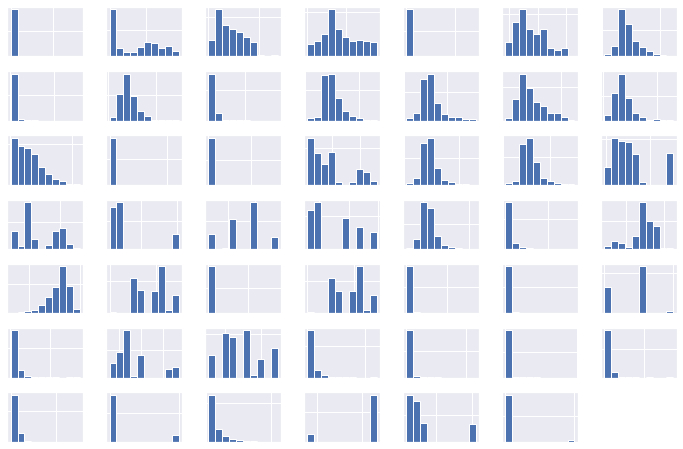

In [14]:
ax = data.hist(figsize=(12,8))
for axis in ax.flatten():
    axis.set_title("")
    axis.set_xticklabels([])
    axis.set_yticklabels([])

We can see many different distributions, some with Gaussian-like distributions, others with seemingly exponential or discrete distributions.  Depending on thechoice of modeling algorithms, we would expect scaling the distributions to the same range tobe useful, and perhaps the use of some power transforms

#### Model Test and Baseline Result

We will use k=10, meaning each fold will contain about 937/10 or about 94 examples.  Stratified means that each fold will contain the same mixture of examples by class, that is about 96% to 4% non-spill and spill.Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model.  We will use three repeats.  This means a single model will be fit and evaluated 10×3 (30) times and the mean and standard deviation of these runs will be reported

*To this end, we have mainly used the geometric mean (g-mean) [...]  This measurehas the distinctive property of being independent of the distribution of examplesbetween classes, and is thus robust in circumstances where this distribution mightchange with time or be different in the training and testing sets—Machine Learning for the Detection of Oil Spills in Satellite Radar Images, 1998*

First, we can define a function to load the dataset and split the columns into input andoutput variables.  We will also drop column 22 because the column contains a single value, andthe first column that defines the image patch number.  Theloaddataset()function belowimplements this

In [15]:
def load_dataset(path):
    data = pd.read_csv(path, index_col='0').drop(columns=  '22')
    data = data.values
    X, y = data[:,:-1], data[:, -1]
    y = LabelEncoder().fit_transform(y)
    return X, y

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(geometric_mean_score)
    scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

path = 'data/oil-spill.csv'
X, y = load_dataset(path)
model = DummyClassifier(strategy='uniform') # ref model
scores = evaluate_model(X=X, y=y, model=model)
print("Mean G-Mean: %.3f (%.3f)" %  (np.mean(scores), np.std(scores)))
print(X.shape, y.shape, Counter(y))

Mean G-Mean: 0.418 (0.216)
(937, 47) (937,) Counter({0: 896, 1: 41})


In this case, we can see that the baseline algorithm achieves a G-mean of about 0.47, close to the theoretical maximum of 0.5.  This score provides a lower limit on model skill; any model that achieves an average G-mean above about 0.47 (or really above 0.5) has skill, whereas models that achieve a score below this value do not have skill on this dataset.

#### Evaluate Probabilistic Models

Let’s start by evaluating some probabilistic models on the dataset.  Probabilistic models arethose models that are fit on the data under a probabilistic framework and often perform well in general for imbalanced classification datasets.

 - Logistic Regression (LR)
 - Linear Discriminant Analysis(LDA)
 - Gaussian Naive Bayes(NB)
 
 Both LR and LDA are sensitive to the scale of the input variables, and often expect and/or perform  better  if  input  variables  with  different  scales  are  normalized  or  standardized  as  apre-processing step.

In [22]:
def get_models():
    models = {}
    models['LR'] = Pipeline(steps = [
                ('t', StandardScaler()), 
                ('m', LogisticRegression(solver='lbfgs'))]
                           )
                 
    models['LDA'] = Pipeline(steps = [
                ('t', MinMaxScaler()), 
                ('m', LogisticRegression(solver='lbfgs'))]
                            )
    models['GNB'] = GaussianNB()
    return models

results = {}
for name, pipeline  in get_models().items():
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print(f"{name}-> {np.mean(scores):.3f}, ({np.std(scores):.3f})")


LR-> 0.673, (0.198)
LDA-> 0.098, (0.196)
GNB-> 0.707, (0.202)


You may see some warnings from the LDA algorithm such as:Variables are collinear.  These can  be  safely  ignored  for  now,  but  suggests  that  the  algorithm  could  benefit  from feature selection to remove some of the variables.  In this case, we can see that each algorithm has skill, achieving a mean G-mean above 0.5.  The results suggest that an LDA might be the best performing of the models tested.

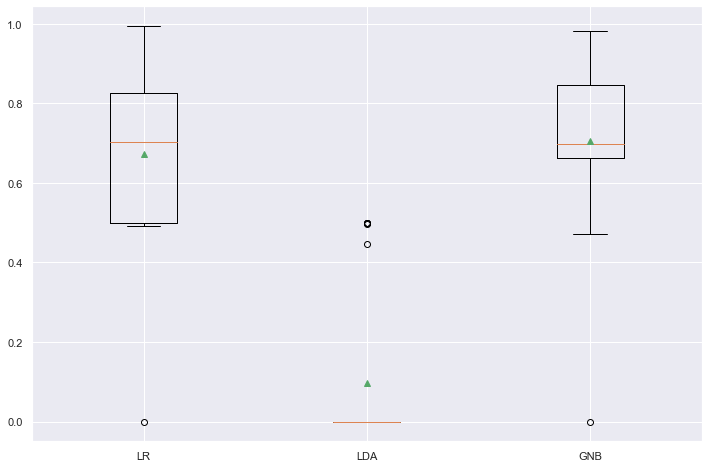

In [23]:
pyplot.figure(figsize=(12,8))
pyplot.boxplot(results.values(), 
               labels= results.keys(), showmeans=True);

#### Evaluate Balanced Logistic Regressio

The  logistic  regression  algorithm  supports  a  modification  that  adjusts  the  importance  ofclassification errors to be inversely proportional to the class weighting.  This allows the modelto better learn the class boundary in favor of the minority class,  which might help overall G-mean  performance.  

As mentioned, logistic regression is sensitive to the scale of input variables and can performbetter with normalized or standardized inputs; as such it is a good idea to test both for a givendataset.  Additionally, a power distribution can be used to spread out the distribution of each and make those variables with a Gaussian-like distribution more Gaussian.  This 
can benefit models like Logistic Regression that make assumptions about the distribution ofinput variables.

In [24]:
LR_ARGS = {'solver':'liblinear', 'class_weight':'balanced'}

def get_models():
    models = {}
    models['balanced'] = Pipeline(steps = [
                 ('m', LogisticRegression(**LR_ARGS))
    ])
                 
    models['balanced_normed'] = Pipeline(steps = [
                ('t', MinMaxScaler()), 
                ('m', LogisticRegression(**LR_ARGS))
    ])
                            
    models['balanced_std'] = Pipeline(steps = [
                ('t', StandardScaler()), 
                ('m', LogisticRegression(**LR_ARGS))
    ])
    
    models['balanced_power'] = Pipeline(steps = [
                ('t1', MinMaxScaler()),
                ('t', PowerTransformer()),
                ('m', LogisticRegression(**LR_ARGS))
    ])
    return models

results = {}
for name, pipeline  in get_models().items():
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print(f"{name}-> {np.mean(scores):.3f}, ({np.std(scores):.3f})")


balanced-> 0.843, (0.123)
balanced_normed-> 0.836, (0.088)
balanced_std-> 0.834, (0.129)
balanced_power-> 0.862, (0.124)


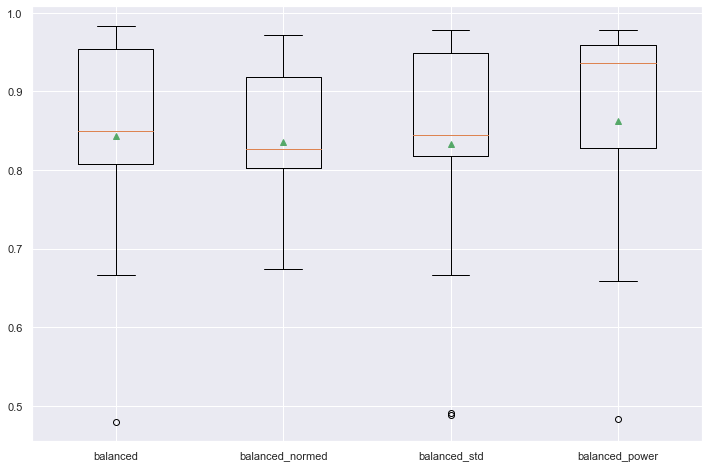

In [25]:
pyplot.figure(figsize=(12,8))
pyplot.boxplot(results.values(), 
               labels= results.keys(), showmeans=True);

 We can see that the distribution for the balanced LR is tighter ingeneral than the non-balanced version in the previous section.  We can also see that the medianresult (orange line) for the normalized version is higher than the mean, above 0.9, which isimpressive.  A mean different from the median suggests a skewed distribution for the results,pulling the mean down with a few bad outcomes

### Evaluate Data Sampling With Probabilistic Models

SMOTE  and  ENN  both  work  better  when  the  input  data  is  scaled  beforehand.   Thisis because both techniques involve using the nearest neighbor algorithm internally and thisalgorithm is sensitive to input variables with different scales. We will compare four variations of the logistic regressionmodel with data sampling.

In [26]:
def get_models():
    models = {}
    sampling = SMOTEENN(enn=
            EditedNearestNeighbours(sampling_strategy = 'majority'))
    model = LogisticRegression(solver='liblinear')
    
    models['LR'] = Pipeline(steps = [('e', sampling), ('m', model)])
    norm = MinMaxScaler()
    models['Norm'] = Pipeline(steps = [('t', norm),
                                      ('e', sampling), ('m', model)])
    std = StandardScaler()
    models['Std'] = Pipeline(steps = [('t', std),
                                      ('e', sampling), ('m', model)])
    
    power_t = PowerTransformer()
    models['Power'] = Pipeline(steps = [('t1', norm),('t2', power_t),
                                      ('e', sampling), ('m', model)]
                             )
    return models

results = {}
for name, pipeline  in get_models().items():
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print(f"{name}-> {np.mean(scores):.3f}, ({np.std(scores):.3f})")

LR-> 0.846, (0.118)
Norm-> 0.828, (0.109)
Std-> 0.831, (0.122)
Power-> 0.883, (0.121)


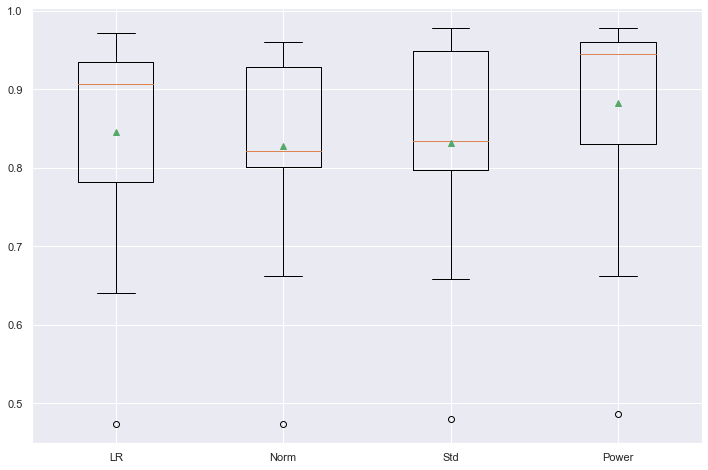

In [27]:
pyplot.figure(figsize=(12,8))
pyplot.boxplot(results.values(), 
               labels= results.keys(), showmeans=True);

In this case, we can see that the addition of SMOTEENN improves the performance of thedefault LR algorithm, achieving a mean G-mean of 0.852 compared to 0.621 seen in the firstset of experimental results.  This is even better than balanced LR without any data scaling(previous section) that achieved a G-mean of about 0.846.

The results suggest that perhaps the final combination of normalization, power transform,and standardization achieves a slightly better score than the default LR with SMOTEENN witha G-mean of about 0.873

#### Make Prediction on New Data

The use of SMOTEENN with Logistic Regression directly without any data scaling probablyprovides the simplest and well-performing model that could be used going forward.  This modelhad a mean G-mean of about 0.852 on our test harness.  We will use this as our final model anduse it to make predictions on new data.  First, we can define the model as a pipeline

In [28]:
sampling = SMOTEENN(enn=
            EditedNearestNeighbours(sampling_strategy = 'majority'))
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('e', sampling), ('m', model)])

X, y = load_dataset(path)

pipeline.fit(X,y)

Pipeline(steps=[('e',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('m', LogisticRegression(solver='liblinear'))])

In [29]:
# evaluate on no spill cases
no_spill_vals = data[data['49'] == 0].drop(columns= '49').sample(15).values
for row in no_spill_vals:
    y_hat = pipeline.predict([row])
    label = y_hat[0]
    print("Predicted=%d (expected 0)" % (label))
print("\n")
spill_vals = data[data['49'] == 1].drop(columns= '49').sample(15).values
for row in spill_vals:
    y_hat = pipeline.predict([row])
    label = y_hat[0]
    print("Predicted=%d (expected 1)" % (label))

Predicted=0 (expected 0)
Predicted=1 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)
Predicted=1 (expected 0)
Predicted=1 (expected 0)
Predicted=0 (expected 0)
Predicted=1 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)
Predicted=0 (expected 0)


Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
Predicted=1 (expected 1)
